In [19]:
from astropy.io import fits
import astropy.constants as c
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

In [20]:
import util

In [21]:
dirname = '20240504'

In [22]:
fpaths = glob.glob(f'{dirname}/*.fits')
print(fpaths)

['20240504/red0018.fits', '20240504/blue0016.fits', '20240504/red0022.fits', '20240504/red0002.fits', '20240504/red0014.fits', '20240504/blue0020.fits', '20240504/blue0021.fits', '20240504/red0015.fits', '20240504/red0003.fits', '20240504/red0023.fits', '20240504/blue0017.fits', '20240504/red0019.fits', '20240504/blue0001.fits', '20240504/red0004.fits', '20240504/red0012.fits', '20240504/blue0026.fits', '20240504/blue0006.fits', '20240504/red0008.fits', '20240504/blue0010.fits', '20240504/red0024.fits', '20240504/red0025.fits', '20240504/blue0011.fits', '20240504/red0009.fits', '20240504/blue0007.fits', '20240504/blue0027.fits', '20240504/red0013.fits', '20240504/red0005.fits', '20240504/blue0024.fits', '20240504/red0010.fits', '20240504/red0006.fits', '20240504/blue0008.fits', '20240504/red0026.fits', '20240504/blue0028.fits', '20240504/blue0012.fits', '20240504/blue0004.fits', '20240504/blue0005.fits', '20240504/blue0013.fits', '20240504/red0027.fits', '20240504/blue0009.fits', '2024

In [23]:
with fits.open('20240504/red0018.fits') as hdul:
    hdul_r18 = hdul
hdul_r18[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4141 / length of data axis 1                          
NAXIS2  =                  440 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = 'none    '        

In [24]:
with fits.open('20240504/blue0018.fits') as hdul:
    hdul_b18 = hdul
hdul_b18[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  460 / length of data axis 1                          
NAXIS2  =                 2835 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = 'none    '        

In [82]:
hdr_keys = ['OBJECT', 'IMGTYPE', 'GAIN', 'EXPTIME', 'UT', 'RA', 'DEC', 'AIRMASS', 'GRATING']

In [83]:
hdr_data = []
data = {}
for fpath in fpaths:
    with fits.open(fpath) as hdul:
        k = re.split(r'/|\.', fpath)[1]
        hdr = hdul[0].header
        hdr_data.append([hdr.get(k, None)  for k in hdr_keys])
        data[k] = hdul[0].data.astype(float)

In [84]:
len(data)

55

In [86]:
hdr_df = pd.DataFrame(hdr_data, columns=hdr_keys, index=[re.split(r'/|\.', fpath)[1] for fpath in fpaths])
hdr_df.index.name = 'filename'
hdr_df.sort_index()

,OBJECT,IMGTYPE,GAIN,EXPTIME,UT,RA,DEC,AIRMASS,GRATING
filename,,,,,,,,,
blue0001,,bias,0.72,0.0,23:16:52.6,06:17:13.70,+33:32:01.8,1.000,600/4000
blue0002,,bias,0.72,0.0,23:17:14.3,06:17:35.45,+33:32:02.6,1.000,600/4000
blue0003,,bias,0.72,0.0,23:17:35.9,06:17:57.11,+33:32:03.3,1.000,600/4000
blue0004,,bias,0.72,0.0,23:17:57.6,06:18:18.89,+33:32:04.1,1.000,600/4000
blue0005,,bias,0.72,0.0,23:18:19.3,06:18:40.64,+33:32:04.8,1.000,600/4000
blue0006,,bias,0.72,0.0,23:18:41.0,06:19:02.40,+33:32:05.6,1.000,600/4000
blue0007,,bias,0.72,0.0,23:19:02.7,06:19:24.16,+33:32:06.3,1.000,600/4000
blue0008,,bias,0.72,0.0,23:19:24.3,06:19:45.80,+33:32:07.1,1.000,600/4000
blue0009,,bias,0.72,0.0,23:19:46.0,06:20:07.57,+33:32:07.9,1.000,600/4000


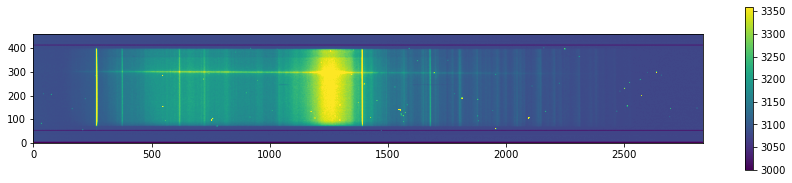

In [29]:
plt.figure(figsize=(15,3))
plt.imshow(data['blue0023'].T, origin='lower', clim=np.percentile(data['blue0023'].T, (1,99)))
plt.colorbar()

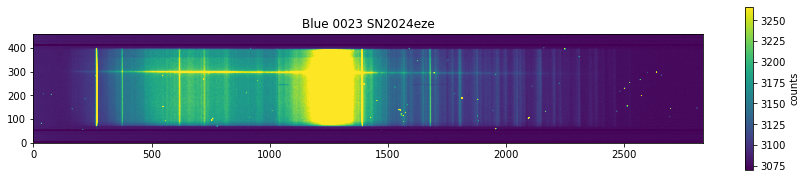

In [30]:
util.plot_frame(data['blue0023'].T, label='counts', title='Blue 0023 SN2024eze', prange=(5,95))

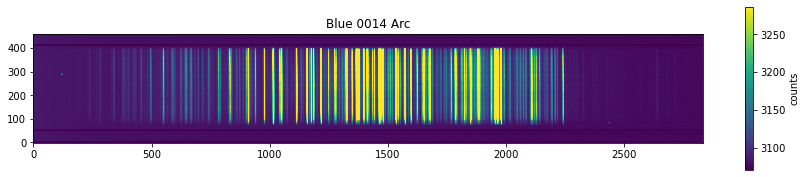

In [31]:
util.plot_frame(data['blue0014'].T, label='counts', title='Blue 0014 Arc', prange=(5,95))

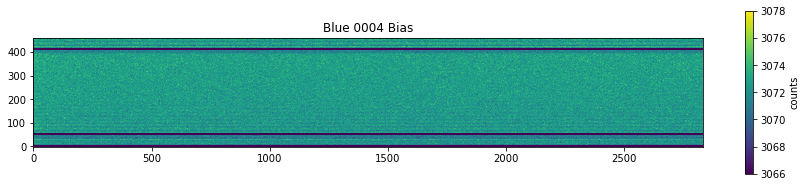

In [32]:
util.plot_frame(data['blue0004'].T, label='counts', title='Blue 0004 Bias', prange=(5,95))

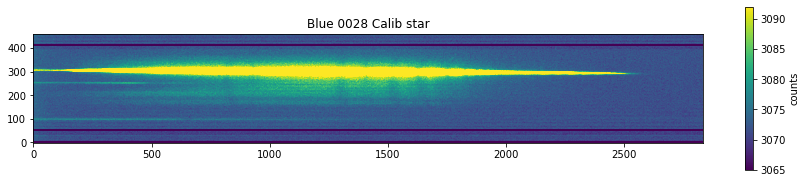

In [33]:
util.plot_frame(data['blue0028'].T, label='counts', title='Blue 0028 Calib star', prange=(5,95))

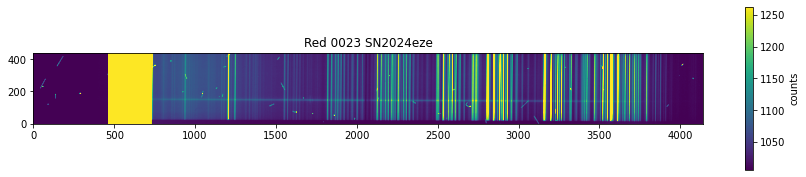

In [34]:
util.plot_frame(data['red0023'], label='counts', title='Red 0023 SN2024eze', prange=(10, 90))

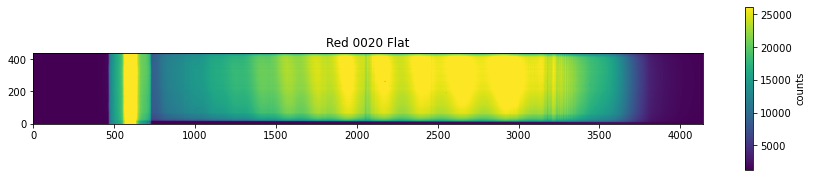

In [35]:
util.plot_frame(data['red0020'], label='counts', title='Red 0020 Flat', prange=(10, 90))

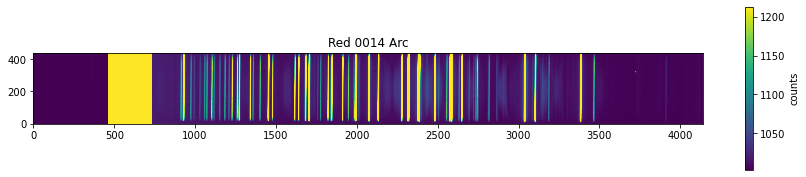

In [36]:
util.plot_frame(data['red0014'], label='counts', title='Red 0014 Arc', prange=(10, 90))

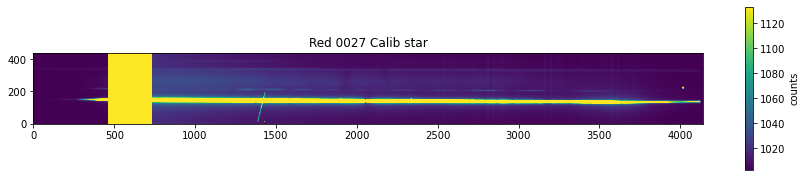

In [37]:
util.plot_frame(data['red0027'], label='counts', title='Red 0027 Calib star', prange=(10, 90))

## Prepare master frames
- for flat, bias, arc (denoted as cal in IMGTYPE), calib star

In [118]:
red_shape = data['red0001'].shape
blue_shape = data['blue0001'].T.shape

red_shape,blue_shape

((440, 4141), (460, 2835))

In [149]:
bias = hdr_df[hdr_df['IMGTYPE'] == 'bias']
flats = hdr_df[hdr_df['IMGTYPE'] == 'flat']
arcs = hdr_df[hdr_df['IMGTYPE'] == 'cal']
calib_star = hdr_df[(hdr_df['IMGTYPE'] == 'object') & (hdr_df['OBJECT'] == 'HD 158261')]

### Master bias (red)

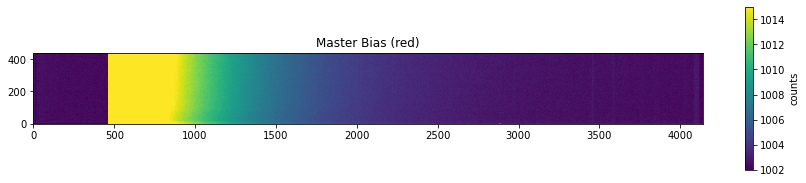

In [150]:
# creating master bias
bias_red = bias[np.char.startswith(list(bias.index), 'red')]
bias_red_layers = np.zeros((red_shape[0], red_shape[1], bias_red.shape[0]))
for i, curr_file in enumerate(bias_red.index):
    curr_data = data[curr_file]
    bias_red_layers[:, :, i] = curr_data

master_bias_red = np.median(bias_red_layers, axis=2)

util.plot_frame(master_bias_red, label='counts', title='Master Bias (red)', prange=(10, 90))

### Master bias (blue)

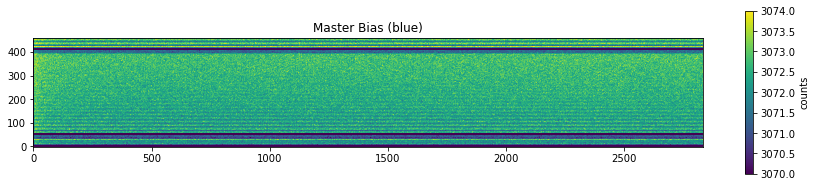

In [151]:
bias_blue = bias[np.char.startswith(list(bias.index), 'blue')]
bias_blue_layers = np.zeros((blue_shape[0], blue_shape[1], bias_blue.shape[0]))
for i, curr_file in enumerate(bias_blue.index):
    curr_data = data[curr_file].T
    bias_blue_layers[:, :, i] = curr_data

master_bias_blue = np.median(bias_blue_layers, axis=2)

util.plot_frame(master_bias_blue, label='counts', title='Master Bias (blue)', prange=(10, 90))

### Master flat (red)

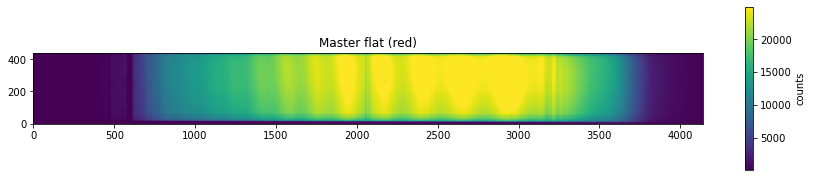

In [152]:
flats_red = flats[np.char.startswith(list(flats.index), 'red')]
flat_red_layers = np.zeros((red_shape[0], red_shape[1], flats_red.shape[0]))
for i, curr_file in enumerate(flats_red.index):
    curr_data = data[curr_file]
    #texp = flats_red.loc[curr_file, 'EXPTIME']
    flat_red_layers[:, :, i] = (curr_data - master_bias_red)   # should be dividing by texp, but all exposure times are zero for flats

master_flat_red = np.median(flat_red_layers, axis=2)
util.plot_frame(master_flat_red, label='counts', title='Master flat (red)', prange=(10, 90))

### Master flat (blue)

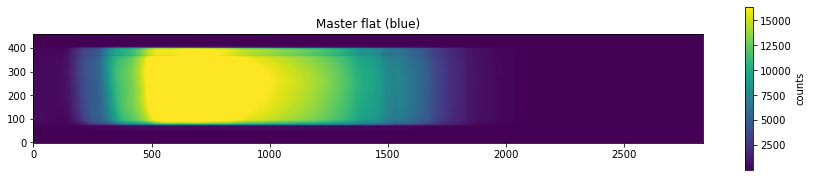

In [154]:
flats_blue = flats[np.char.startswith(list(flats.index), 'blue')]
flat_blue_layers = np.zeros((blue_shape[0], blue_shape[1], flats_blue.shape[0]))
for i, curr_file in enumerate(flats_blue.index):
    curr_data = data[curr_file].T
    #texp = flats_red.loc[curr_file, 'EXPTIME']
    flat_blue_layers[:, :, i] = (curr_data - master_bias_blue)   # should be dividing by texp, but all exposure times are zero for flats

master_flat_blue = np.median(flat_blue_layers, axis=2)
util.plot_frame(master_flat_blue, label='counts', title='Master flat (blue)', prange=(10, 90))

### Master arc (red)

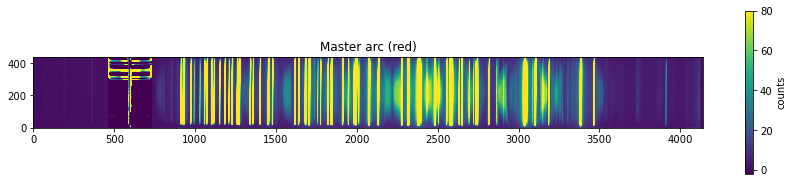

In [163]:
arcs_red = arcs[np.char.startswith(list(arcs.index), 'red')]
arcs_red_layers = np.zeros((red_shape[0], red_shape[1], arcs_red.shape[0]))
for i, curr_file in enumerate(arcs_red.index):
    curr_data = data[curr_file]
    texp = arcs_red.loc[curr_file, 'EXPTIME']
    arcs_red_layers[:, :, i] = (curr_data - master_bias_red) / texp

master_arc_red = np.median(arcs_red_layers, axis=2)
util.plot_frame(master_arc_red, label='counts', title='Master arc (red)', prange=(10, 90))

### Master arc (blue)

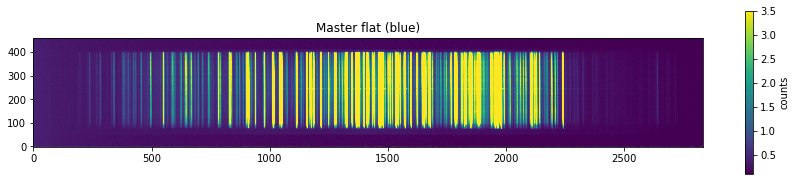

In [160]:
arcs_blue = arcs[np.char.startswith(list(arcs.index), 'blue')]
arcs_blue_layers = np.zeros((blue_shape[0], blue_shape[1], arcs_blue.shape[0]))
for i, curr_file in enumerate(arcs_blue.index):
    curr_data = data[curr_file].T
    texp = arcs_blue.loc[curr_file, 'EXPTIME']
    arcs_blue_layers[:, :, i] = (curr_data - master_bias_blue) / texp

master_arc_blue = np.median(arcs_blue_layers, axis=2)
util.plot_frame(master_arc_blue, label='counts', title='Master arc (blue)', prange=(10, 90))

## Rectify frames
- use calib star as trace - don't need
- X, Y already aligned - just needs trimming, crosscheck with TSEC1 in header

## Reduce frames 
- subtract bias, divide by normalised flat

## Wavelength calibration
- use arc to derive a px to wvl solution

In [ ]:
# identifying arcs using calibration spectrum
hdul_fear = fits.open('scidoc2214.fits')

data_fear = hdul_fear['PRIMARY'].data.astype(float)
n_px = len(data_fear)
hdr_fear = hdul_fear[0].header

spectrum_range = [3000, 10900]  # angstroms
spectral_resolution = np.diff(spectrum_range) / n_px  # Å/pix
spectral_resolution

## Airmass correction 
- use airmass extinction to find zero airmass flux for calib star 

## Flux calibration
- Source and BG extraction on calib star
- Derive counts to photons conversion factor

## Rectify, reduce, airmass-correct science data
- All above steps on science data to extract spectrum from images